In [1]:
import pandas as pd
import pickle
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl
from cellink.tl._burden_testing import *

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_chr22=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr22_all_results.pkl")

In [3]:
results_chr22

burden_gene      target_gene              burden_type    pvalue  \
0   ENSG00000100181  ENSG00000100181               CADD_PHRED  0.410408   
1   ENSG00000100181  ENSG00000100181                DNA_LM_up  0.455557   
2   ENSG00000100181  ENSG00000100181              DNA_LM_down  0.405714   
3   ENSG00000100181  ENSG00000100181            MAF_beta_1.25  0.438648   
4   ENSG00000100181  ENSG00000100181             DNA_LM_mixed  0.455557   
..              ...              ...                      ...       ...   
2   ENSG00000079974  ENSG00000079974              DNA_LM_down  0.566378   
3   ENSG00000079974  ENSG00000079974            MAF_beta_1.25  0.362695   
4   ENSG00000079974  ENSG00000079974             DNA_LM_mixed  0.581252   
5   ENSG00000079974  ENSG00000079974        GENE_TSS_DISTANCE  0.123626   
6   ENSG00000079974  ENSG00000079974  GENE_TSS_DISTANCE_SAIGE  0.905927   

        beta cell_type chromosome  
0  -0.173248    CD8 ET         22  
1  -0.157398    CD8 ET         22  
2  -0.175694    CD8 ET         22  
3  -0.164011    CD8 ET         22  
4  -0.157398    CD8 ET         22  
..       ...       ...        ...  
2  -0.032154    CD8 NC         22  
3   0.051364    CD8 NC         22  
4  -0.030930    CD8 NC         22  
5   0.086877    CD8 NC         22  
6  -0.006611    CD8 NC         22  

[6405 rows x 7 columns]

### Correcting p values

In [179]:
from statsmodels.stats.multitest import multipletests

In [31]:
results_chr22["pvalue_corrected"] = results_chr22["pvalue"] * len(results_chr22)
results_chr22["significant"] = results_chr22["pvalue_corrected"] < 0.05

In [202]:
#results_chr22[(results_chr22["cell_type"]=="CD8 ET") & (results_chr22[burden_type]) ]

df=results_chr22.copy()
df_to_plot = pd.DataFrame(columns=['celltype', 'weight', 'n'])
# extract different weight results per gene
celltypes= ["CD8 ET", "CD8 NC"]


for celltype in celltypes:
    df_weights={}
    for weight in df["burden_type"].unique():
        df_weights[weight] = df[(df["cell_type"] == celltype) & (df["burden_type"]==weight)]
        
        _, df_weights[weight]["FDR_corrected"], _, _ = multipletests(df_weights[weight]["pvalue"], alpha=0.05, method='fdr_bh')
        

        df_to_plot = pd.concat([df_to_plot, pd.DataFrame({
                'celltype': [celltype],
                'weight': [weight],
                'n': [len(df_weights[weight][df_weights[weight]["FDR_corrected"] < 0.05])]
            })], ignore_index=True)

df_to_plot['celltype_weight'] = df_to_plot['celltype'] + "_" + df_to_plot['weight']
df_to_plot

/scratch/tmp/l_back/ipykernel_2758367/1540276508.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/l_back/ipykernel_2758367/1540276508.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/l_back/ipykernel_2758367/1540276508.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

celltype                   weight  n                 celltype_weight
0    CD8 ET               CADD_PHRED  0               CD8 ET_CADD_PHRED
1    CD8 ET                DNA_LM_up  0                CD8 ET_DNA_LM_up
2    CD8 ET              DNA_LM_down  0              CD8 ET_DNA_LM_down
3    CD8 ET            MAF_beta_1.25  0            CD8 ET_MAF_beta_1.25
4    CD8 ET             DNA_LM_mixed  1             CD8 ET_DNA_LM_mixed
5    CD8 ET        GENE_TSS_DISTANCE  0        CD8 ET_GENE_TSS_DISTANCE
6    CD8 ET  GENE_TSS_DISTANCE_SAIGE  2  CD8 ET_GENE_TSS_DISTANCE_SAIGE
7    CD8 NC               CADD_PHRED  0               CD8 NC_CADD_PHRED
8    CD8 NC                DNA_LM_up  0                CD8 NC_DNA_LM_up
9    CD8 NC              DNA_LM_down  0              CD8 NC_DNA_LM_down
10   CD8 NC            MAF_beta_1.25  0            CD8 NC_MAF_beta_1.25
11   CD8 NC             DNA_LM_mixed  0             CD8 NC_DNA_LM_mixed
12   CD8 NC        GENE_TSS_DISTANCE  0        CD8 NC_GENE_TSS_DISTANCE
13   CD8 NC  GENE_TSS_DISTANCE_SAIGE  2  CD8 NC_GENE_TSS_DISTANCE_SAIGE

[2025-01-23 18:18:57,495] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


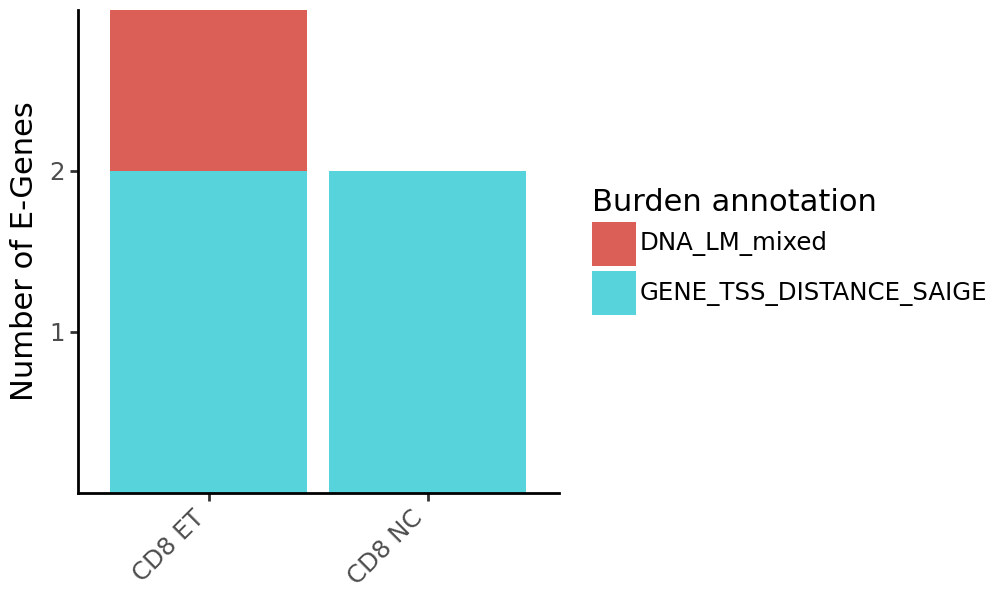

In [208]:

zero_types = list(df_to_plot.query("n==0")["celltype_weight"])
from plotnine import *
plot = (
    ggplot(df_to_plot.query("celltype_weight not in @zero_types"), 
           aes(x='celltype', y='n'))  # Specify the x and y variables
    + geom_bar(aes(fill = "weight"), stat = "identity")  # Add the boxplot layer
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (5,3)) 
            #legend_position="none")
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")
    #+ scale_fill_manual(values = ['darkred', "grey", "blue", "green"], labels = ["GENE_TSS_DISTANCE", "GENE_TSS_DISTANCE_SAIGE", "CADD_PHRED", "DNA_LM_down","DNA_LM_up","DNA_LM_mixed", "MAF_beta_1.25"])
)
plot

In [180]:
# Benjamini hochberg
rejected, fdr_values, _, _ = multipletests(results_chr22["pvalue"], alpha=0.05, method='fdr_bh')


In [191]:
results_chr22[fdr_values<0.05]

burden_gene      target_gene              burden_type    pvalue  \
6  ENSG00000100359  ENSG00000100359  GENE_TSS_DISTANCE_SAIGE  0.000001   
6  ENSG00000230319  ENSG00000230319  GENE_TSS_DISTANCE_SAIGE  0.000007   
6  ENSG00000100219  ENSG00000100219  GENE_TSS_DISTANCE_SAIGE  0.000018   

       beta cell_type chromosome  pvalue_corrected  significant  
6 -0.175106    CD8 ET         22          0.006794         True  
6  0.363820    CD8 ET         22          0.046438         True  
6  0.036681    CD8 NC         22          0.118312        False

In [188]:
fdr_values

array([0.97726211, 0.97726211, 0.97726211, ..., 0.98172934, 0.97726211,
       0.99971078])

In [187]:
 results_chr22["burden_gene"][results_chr22["pvalue_corrected"]<0.05]


6    ENSG00000100359
6    ENSG00000230319
Name: burden_gene, dtype: object

In [30]:
results_chr22

burden_gene      target_gene              burden_type    pvalue  \
0   ENSG00000100181  ENSG00000100181               CADD_PHRED  0.410408   
1   ENSG00000100181  ENSG00000100181                DNA_LM_up  0.455557   
2   ENSG00000100181  ENSG00000100181              DNA_LM_down  0.405714   
3   ENSG00000100181  ENSG00000100181            MAF_beta_1.25  0.438648   
4   ENSG00000100181  ENSG00000100181             DNA_LM_mixed  0.455557   
..              ...              ...                      ...       ...   
2   ENSG00000079974  ENSG00000079974              DNA_LM_down  0.566378   
3   ENSG00000079974  ENSG00000079974            MAF_beta_1.25  0.362695   
4   ENSG00000079974  ENSG00000079974             DNA_LM_mixed  0.581252   
5   ENSG00000079974  ENSG00000079974        GENE_TSS_DISTANCE  0.123626   
6   ENSG00000079974  ENSG00000079974  GENE_TSS_DISTANCE_SAIGE  0.905927   

        beta cell_type chromosome  pvalue_corrected  significant  
0  -0.173248    CD8 ET         22       2628.662194        False  
1  -0.157398    CD8 ET         22       2917.841313        False  
2  -0.175694    CD8 ET         22       2598.597709        False  
3  -0.164011    CD8 ET         22       2809.541081        False  
4  -0.157398    CD8 ET         22       2917.841313        False  
..       ...       ...        ...               ...          ...  
2  -0.032154    CD8 NC         22       3627.653479        False  
3   0.051364    CD8 NC         22       2323.062541        False  
4  -0.030930    CD8 NC         22       3722.920011        False  
5   0.086877    CD8 NC         22        791.825784        False  
6  -0.006611    CD8 NC         22       5802.460611        False  

[6405 rows x 9 columns]

## Only 2 significant e genes

In [20]:
results_chr22[results_chr22["significant"] ]

burden_gene      target_gene              burden_type    pvalue  \
6  ENSG00000100359  ENSG00000100359  GENE_TSS_DISTANCE_SAIGE  0.000001   
6  ENSG00000230319  ENSG00000230319  GENE_TSS_DISTANCE_SAIGE  0.000007   

       beta cell_type chromosome  pvalue_corrected  significant  
6 -0.175106    CD8 ET         22          0.006794         True  
6  0.363820    CD8 ET         22          0.046438         True

In [21]:
e_genes_per_cell_type = results_chr22\
    .groupby(["cell_type", "burden_type"])["significant"].sum()\
    .to_frame(name = "count").reset_index()
e_genes_per_cell_type

cell_type              burden_type  count
0     CD8 ET               CADD_PHRED      0
1     CD8 ET              DNA_LM_down      0
2     CD8 ET             DNA_LM_mixed      0
3     CD8 ET                DNA_LM_up      0
4     CD8 ET        GENE_TSS_DISTANCE      0
5     CD8 ET  GENE_TSS_DISTANCE_SAIGE      2
6     CD8 ET            MAF_beta_1.25      0
7     CD8 NC               CADD_PHRED      0
8     CD8 NC              DNA_LM_down      0
9     CD8 NC             DNA_LM_mixed      0
10    CD8 NC                DNA_LM_up      0
11    CD8 NC        GENE_TSS_DISTANCE      0
12    CD8 NC  GENE_TSS_DISTANCE_SAIGE      0
13    CD8 NC            MAF_beta_1.25      0

[2025-01-23 09:42:36,523] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


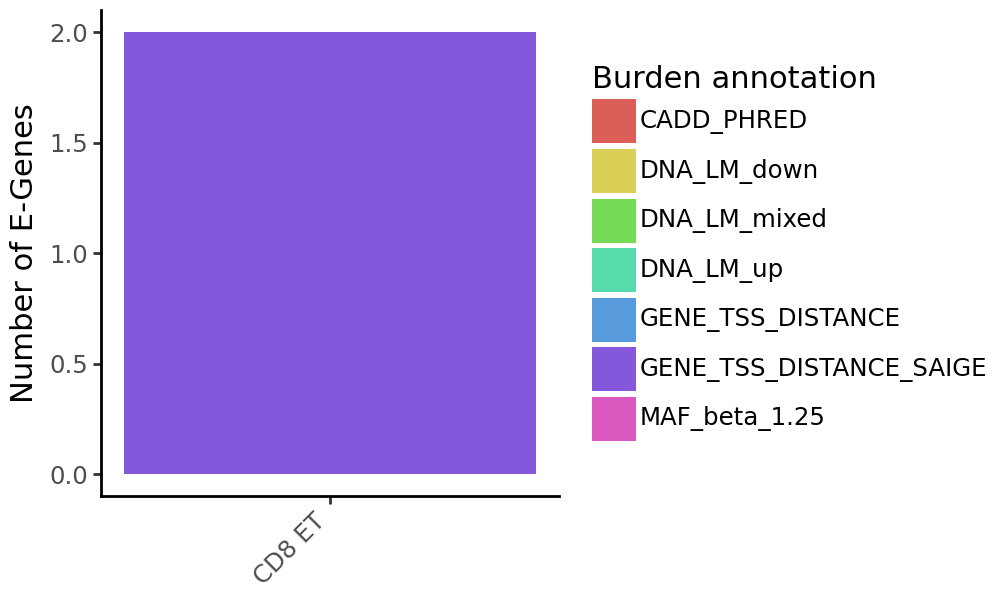

In [22]:
zero_types = list(e_genes_per_cell_type.groupby("cell_type").sum().query("count ==0").index)
from plotnine import *
plot = (
    ggplot(e_genes_per_cell_type.query("cell_type not in @zero_types"), 
           aes(x='cell_type', y='count'))  # Specify the x and y variables
    + geom_bar(aes(fill = "burden_type"), stat = "identity")  # Add the boxplot layer
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (5,3)) 
            #legend_position="none")
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")
    #+ scale_fill_manual(values = ['darkred', "grey", "blue", "green"], labels = ["GENE_TSS_DISTANCE", "GENE_TSS_DISTANCE_SAIGE", "CADD_PHRED", "DNA_LM_down","DNA_LM_up","DNA_LM_mixed", "MAF_beta_1.25"])
)
plot

[2025-01-23 09:52:29,122] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


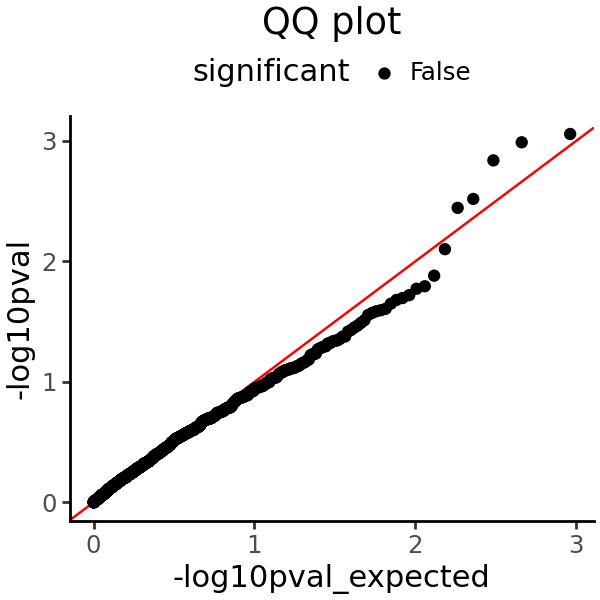

In [33]:
df = results_chr22.copy().query("burden_type == 'MAF_beta_1.25'")

df = df.sort_values("pvalue")
df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))

if "-log10pval" not in df.columns:
    df["-log10pval"] = -np.log10(df["pvalue"])

aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
plot = (
    ggplot(df, aes(**aes_kwargs, color="significant"))
    + labs(title="QQ plot")
    + scale_color_manual(values = ["black", "red"])
    + theme_classic()
    + geom_abline(intercept=0, slope=1, color="red")
    + geom_point()
    + theme(legend_position="top", figure_size = (3,3))
)
plot

## Pseudobulk computation and plot recreation
-> for cell type "CD8 ET"

In [35]:



data_chr22 = pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/annotations/chr22_data.pkl")



In [52]:
scdata_cell

AnnData object with n_obs × n_vars = 1 × 655
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features', 'chromosome', 'start', 'end'
    uns: 'log1p'

In [88]:

from cellink.tl._eqtl import _get_pb_data

In [87]:
data_chr22 = pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/annotations/chr22_data.pkl")

scdata_cell = data_chr22.adata["cell_label" == "CD8 ET"].copy()

_pseudobulk_scdata(scdata_cell, "individual","sex", "age" ,"mean")


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


AnnData object with n_obs × n_vars = 1 × 655
    obs: 'individual', 'sex', 'age'
    var: 'GeneSymbol', 'features', 'chromosome', 'start', 'end'
    layers: 'mean'

In [92]:
all_burdens_chr22 = pd.read_parquet("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/burdens/chr22_all_burdens.parquet")

eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)
eigenvec.index = eigenvec[1]
eigenvec = eigenvec.iloc[:, 2:]
eigenvec = eigenvec[eigenvec.index.isin(all_burdens_chr22.index.unique())]

In [93]:

pb_data=_get_pb_data(
    scdata=data_chr22.adata,
    gdata=data_chr22.gdata,
    cell_type= "CD8 ET",
    target_chromosome= "22",
    donor_key_in_scdata = "individual",
    sex_key_in_scdata = "sex",
    age_key_in_scdata = "age",
    pseudobulk_aggregation_type= "mean",
    min_individuals_threshold= 10,
    n_top_genes = 5_000,
    n_sc_comps= 15,
    n_genetic_pcs= 20,
    n_cellstate_comps= 50,
    eigenvector_df=eigenvec
)

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


[2025-01-23 11:15:44,965] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-23 11:15:44,965] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-23 11:15:44,966] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


In [165]:
# using burden scores (for a specific gene and annotation)
#  and the pseudobulk expression for this gene (added later)

test=pd.DataFrame(all_burdens_chr22[ all_burdens_chr22["Geneid"]=="ENSG00000100181"]["CADD_PHRED"])
#pb_data.adata.layers["mean"]

In [174]:
pb_data_all_genes = pb_data.adata.layers["mean"]
pb_by_gene_df = pd.DataFrame(pb_data_all_genes, columns=pb_data.adata.var_names, index=pb_data.adata.obs_names)
#pb_data.adata.layers["mean"]#["ENSG00000233866"]

In [175]:
# Geneid is misleading, the column is the patient
pb_by_gene_df

Geneid     ENSG00000100181  ENSG00000237438  ENSG00000177663  ENSG00000183307  \
1_1               0.092711         0.000000         0.206655              0.0   
2_2               0.061852         0.000000         0.194430              0.0   
3_3               0.031793         0.030314         0.145861              0.0   
4_4               0.038197         0.000000         0.230582              0.0   
6_6               0.000000         0.000000         0.087585              0.0   
...                    ...              ...              ...              ...   
1077_1078         0.079500         0.000000         0.153368              0.0   
1078_1079         0.000000         0.000000         0.146611              0.0   
1079_1080         0.115054         0.000000         0.154732              0.0   
1080_1081         0.072514         0.000000         0.161341              0.0   
1081_1082         0.080598         0.009520         0.275439              0.0   

Geneid     ENSG00000069998  ENSG00000185837  ENSG00000093072  ENSG00000182902  \
1_1               0.238997         0.000000         0.219405         0.000000   
2_2               0.214892         0.000000         0.309812         0.000000   
3_3               0.060655         0.000000         0.267325         0.000000   
4_4               0.230291         0.000000         0.215271         0.030872   
6_6               0.146268         0.000000         0.089190         0.000000   
...                    ...              ...              ...              ...   
1077_1078         0.201822         0.000000         0.374817         0.000000   
1078_1079         0.243328         0.000000         0.000000         0.000000   
1079_1080         0.119868         0.000000         0.319450         0.040261   
1080_1081         0.180088         0.000000         0.223639         0.000000   
1081_1082         0.221022         0.012152         0.303898         0.000000   

Geneid     ENSG00000131100  ENSG00000099968  ...  ENSG00000272666  \
1_1               0.724544         0.165597  ...              0.0   
2_2               0.536144         0.197722  ...              0.0   
3_3               0.415425         0.263236  ...              0.0   
4_4               0.267505         0.174526  ...              0.0   
6_6               0.542774         0.230625  ...              0.0   
...                    ...              ...  ...              ...   
1077_1078         0.357274         0.131576  ...              0.0   
1078_1079         0.320589         0.075446  ...              0.0   
1079_1080         0.530532         0.205203  ...              0.0   
1080_1081         0.708908         0.195301  ...              0.0   
1081_1082         0.488537         0.189048  ...              0.0   

Geneid     ENSG00000273272  ENSG00000130487  ENSG00000217442  ENSG00000205560  \
1_1               0.000000         0.131899              0.0         0.052000   
2_2               0.000000         0.116429              0.0         0.029930   
3_3               0.000000         0.060093              0.0         0.000000   
4_4               0.000000         0.033883              0.0         0.000000   
6_6               0.000000         0.000000              0.0         0.000000   
...                    ...              ...              ...              ...   
1077_1078         0.000000         0.226545              0.0         0.000000   
1078_1079         0.000000         0.074009              0.0         0.000000   
1079_1080         0.000000         0.120954              0.0         0.039848   
1080_1081         0.017901         0.143987              0.0         0.018569   
1081_1082         0.000000         0.052474              0.0         0.032108   

Geneid     ENSG00000100288  ENSG00000205559  ENSG00000008735  ENSG00000100299  \
1_1               0.106033         0.018527         0.019309         0.130664   
2_2               0.178261         0.073018         0.000000         0.116724   
3_3      

In [176]:
test["expression"]=pb_by_gene_df["ENSG00000100181"]

In [177]:
test["Cell type"]= "CD8 ET"

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


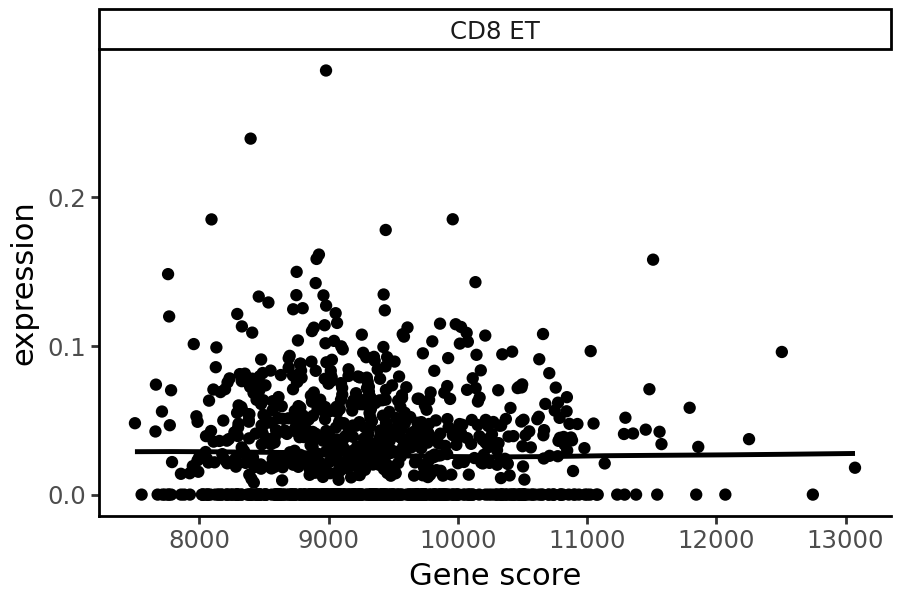

In [178]:
plot = (
    ggplot(test, aes(x = "CADD_PHRED", y = "expression"))
    + labs(x = "Gene score")
    + theme_classic()
    + geom_smooth()
    + geom_point()
    + facet_wrap("Cell type", scales = "free")
    + theme(legend_position="top", figure_size = (4.5,3))
)
plot

## correction on cauchy

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

# Example DataFrame (replace this with your actual data)
df = pd.DataFrame({
    'celltype': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Group': ['Cauchy', 'Cauchy', 'Cauchy', 'Cauchy', 'Other', 'Cauchy'],
    'Pvalue': [0.01, 0.2, 0.03, 0.5, 0.4, 0.02]
})

# Unique cell types
celltypes = df['celltype'].unique()

# Initialize results DataFrame
df_to_plot = pd.DataFrame(columns=['celltype', 'n_cauchy'])

# Loop over cell types
for celltype in celltypes:
    # Filter data for current cell type and Group == "Cauchy"
    df0 = df[(df['celltype'] == celltype) & (df['Group'] == "Cauchy")].copy()
    
    # Drop rows with all NaN values
    df0 = df0.dropna(how='all')
    
    # Compute q-values
    if not df0.empty:
        _, q_values, _, _ = multipletests(df0['Pvalue'], method='fdr_bh')
        df0['qv'] = q_values
    
        # Count significant results (qv < 0.05)
        n_cauchy = (df0['qv'] < 0.05).sum()
    else:
        n_cauchy = 0
    
    # Append results
    df_to_plot = pd.concat([df_to_plot, pd.DataFrame({'celltype': [celltype], 'n_cauchy': [n_cauchy]})], ignore_index=True)

# Display results
print(df_to_plot)
